📂 현재 작업 위치: d:\portfolio\vga-price-forecaster\src
📂 데이터셋 경로 : d:\portfolio\vga-price-forecaster\Dataset\VGA_Total
✅ 경로 연결 성공!
🔍 RTX 5060 탐색적 데이터 분석(EDA) 리포트


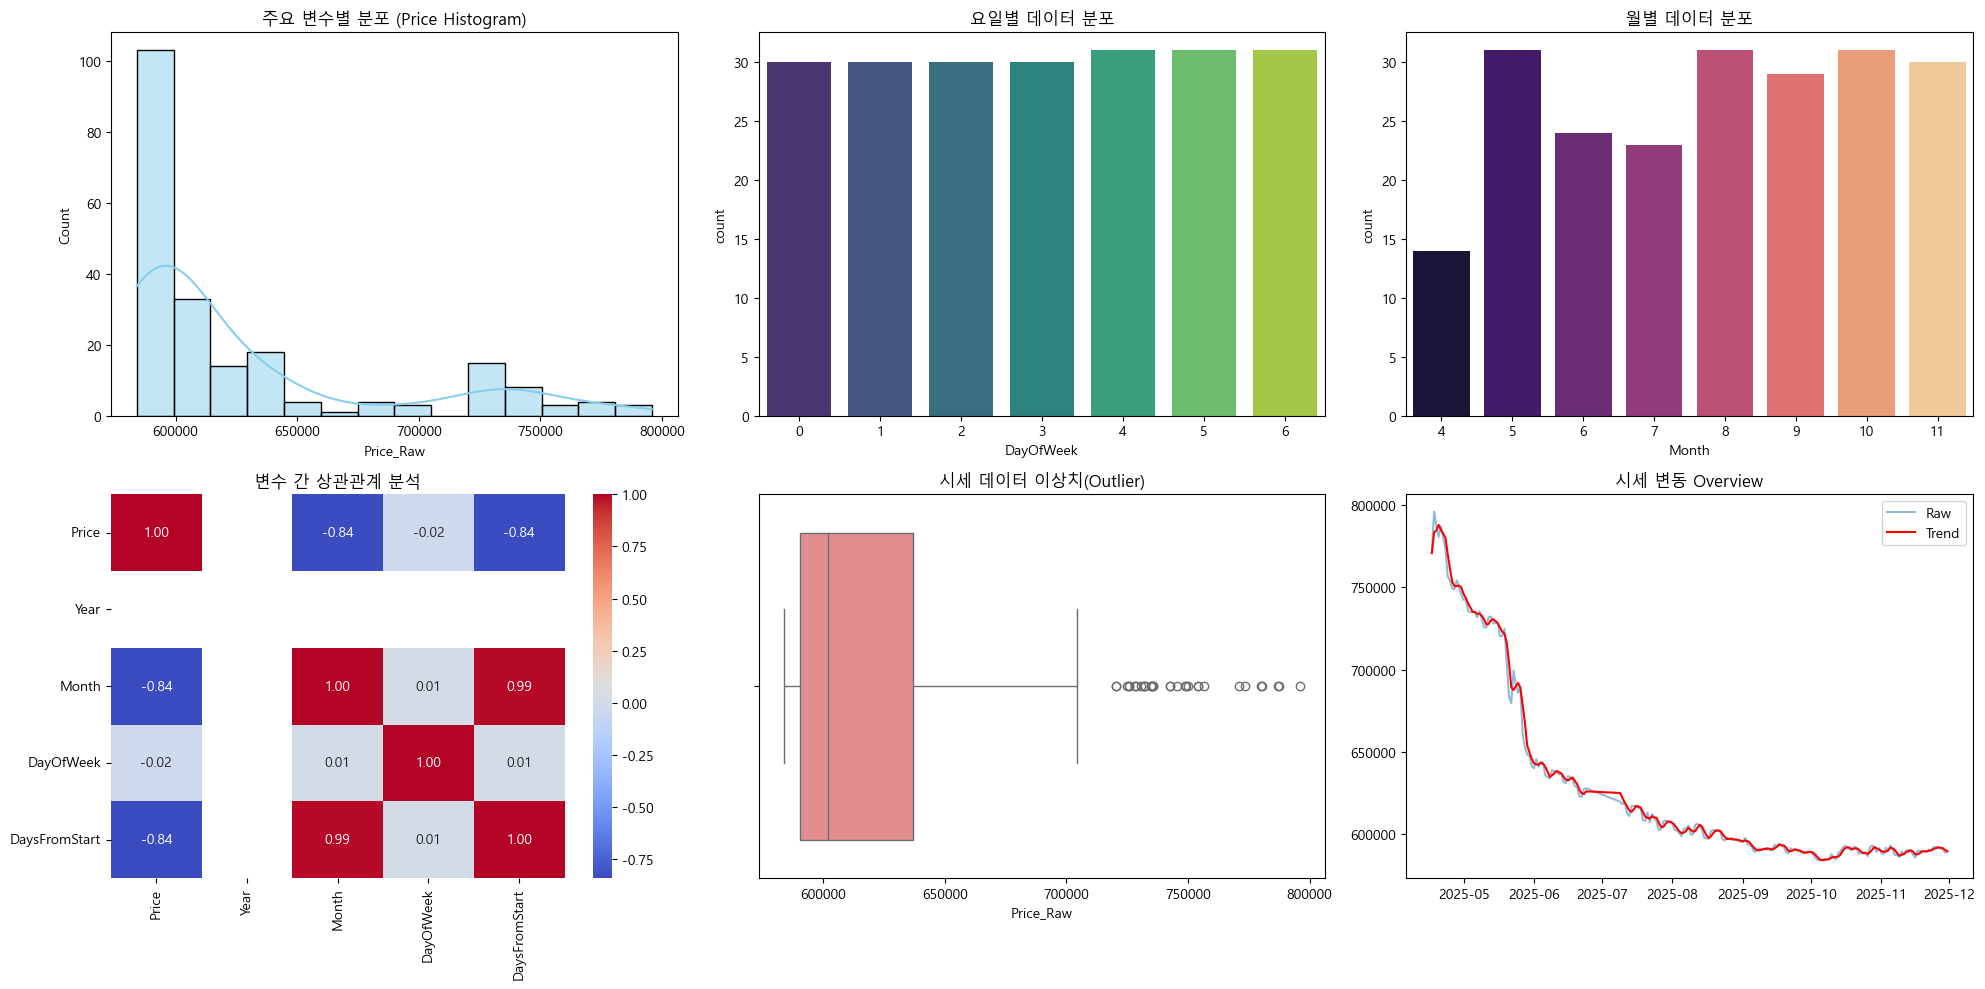

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0125
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0256e-04
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3215e-04
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9400e-04
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3988e-04
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1427e-04
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2852e-04
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2549e-04
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0533e-04
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - 


🤖 AI 모델 성능 평가 지표 (Overview)
1. R2 Score (결정계수): 0.9644
2. MAE (평균 절대 오차): 3,376원
3. MSE (평균 제곱 오차): 31,026,443
4. RMSE (평균 제곱근 오차): 5,570원
✅ 저장 완료:
 - 모델: d:\portfolio\vga-price-forecaster\models\vga_RTX_5060_model.h5
 - 스케일러: d:\portfolio\vga-price-forecaster\models\vga_RTX_5060_scaler.pkl


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import warnings
import joblib
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 경고 메세지 무시 및 폰트 설정
warnings.filterwarnings('ignore')
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 재현성 확보
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

current_dir = os.getcwd()

# 파일 경로 설정
if os.path.basename(current_dir) == 'src':
    BASE_DIR = os.path.dirname(current_dir) 
else:
    BASE_DIR = current_dir

# 데이터셋 경로 설정
VGA_PATH = os.path.join(BASE_DIR, 'Dataset', 'VGA_Total')

# 경로 확인용 로그
print(f"📂 현재 작업 위치: {current_dir}")
print(f"📂 데이터셋 경로 : {VGA_PATH}")

if not os.path.exists(VGA_PATH):
    print("❌ 경로서 설정 오류! 경로를 찾을 수 없습니다.")
else:
    print("✅ 경로 연결 성공!")

# 학습할 그래픽 카드 종류 입력
TARGET_MODEL = "RTX 5060"

# 데이터 로드 및 전처리
def load_vga_integrated(path, target):
    all_data = []
    files = sorted([f for f in os.listdir(path) if f.endswith('.csv')])
    for f in files:
        file_path = os.path.join(path, f)
        df_tmp = None
        for enc in ['utf-8', 'cp949']:
            try: df_tmp = pd.read_csv(file_path, encoding=enc); break
            except: continue
        if df_tmp is None: continue
        
        rows = df_tmp[df_tmp['Name'].str.contains(target, na=False, case=False)]
        cols = [c for c in df_tmp.columns if re.match(r'\d{4}-\d{2}-\d{2}', c)]
        for col in cols:
            p = pd.to_numeric(rows[col].astype(str).str.replace(',', '').str.extract('(\d+)')[0], errors='coerce')
            valid = p[p > 10000]
            if not valid.empty:
                all_data.append({'Date': col.split(' ')[0], 'Price': valid.mean()})
    
    if not all_data:
        return None

    df = pd.DataFrame(all_data).groupby('Date')['Price'].mean().reset_index()
    df['Date_dt'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date_dt')
    
    # 파생 변수 생성(Feature Engineering)
    df['Year'] = df['Date_dt'].dt.year  # 연도
    df['Month'] = df['Date_dt'].dt.month    # 월 (계절성 분석용)
    df['DayOfWeek'] = df['Date_dt'].dt.dayofweek    # 요일(주말/주중 패턴 분석)
    
    # AI 학습용 연속 시간 변수
    df['DaysFromStart'] = (df['Date_dt'] - df['Date_dt'].min()).dt.days
    
    # 노이즈 제거
    df['Price_Raw'] = df['Price']
    df['Price_Smooth'] = df['Price'].rolling(window=3, min_periods=1).mean()
    return df

df = load_vga_integrated(VGA_PATH, TARGET_MODEL)

if df is not None and len(df) > 30:
    # 주요 변수별 히스토그램 및 탐색적 분석
    print(f"🔍 {TARGET_MODEL} 탐색적 데이터 분석(EDA) 리포트")
    plt.figure(figsize=(20, 10))

    # (1) 주요 변수 히스토그램 (가격 분포)
    plt.subplot(2, 3, 1)
    sns.histplot(df['Price_Raw'], kde=True, color='skyblue')
    plt.title('주요 변수별 분포 (Price Histogram)')

    # (2) 요일별 데이터 분포 히스토그램
    plt.subplot(2, 3, 2)
    sns.countplot(data=df, x='DayOfWeek', palette='viridis')
    plt.title('요일별 데이터 분포')

    # (3) 월별 데이터 분포 히스토그램
    plt.subplot(2, 3, 3)
    sns.countplot(data=df, x='Month', palette='magma')
    plt.title('월별 데이터 분포')

    # (4) 5x5 상관관계 히트맵 (Heatmap)
    plt.subplot(2, 3, 4)
    sns.heatmap(df[['Price','Year','Month','DayOfWeek','DaysFromStart']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('변수 간 상관관계 분석')

    # (5) 이상치 분석 (Boxplot)
    plt.subplot(2, 3, 5)
    sns.boxplot(x=df['Price_Raw'], color='lightcoral')
    plt.title('시세 데이터 이상치(Outlier)')

    # (6) 시세 추이 오버뷰
    plt.subplot(2, 3, 6)
    plt.plot(df['Date_dt'], df['Price_Raw'], alpha=0.5, label='Raw')
    plt.plot(df['Date_dt'], df['Price_Smooth'], color='red', label='Trend')
    plt.legend()
    plt.title('시세 변동 Overview')

    plt.tight_layout()
    plt.show()

    # 모델 학습 데이터 준비
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['Price_Smooth']])
    SEQ_LENGTH = 30
    X, y = [], []
    for i in range(len(scaled_data) - SEQ_LENGTH):
        X.append(scaled_data[i:i+SEQ_LENGTH])
        y.append(scaled_data[i+SEQ_LENGTH])
    X, y = np.array(X), np.array(y)

    # LSTM 모델 빌드 및 학습
    model = Sequential([
        Input(shape=(SEQ_LENGTH, 1)),   
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dense(1)
    ])

    # LSTM 컴파일
    model.compile(optimizer='adam', loss='huber')
    
    # 50회 반복 학습
    model.fit(X, y, epochs=50, batch_size=16, verbose=1, shuffle=False)

    # 성능 평가지표 출력 (R2, MAE, MSE, RMSE)
    y_pred_scaled = model.predict(X, verbose=0)
    y_pred = scaler.inverse_transform(y_pred_scaled)    # 0 ~ 1 학습값을 (원)단위로 번역
    y_actual = df['Price_Smooth'].values[SEQ_LENGTH:]   # 1 ~ 30 까지의 데이터 잘라낸 이후의 31부터 비교 및 채점

    mse = mean_squared_error(y_actual, y_pred)
    print("\n" + "="*30)
    print("🤖 AI 모델 성능 평가 지표 (Overview)")
    print("="*30)
    print(f"1. R2 Score (결정계수): {r2_score(y_actual, y_pred):.4f}")
    print(f"2. MAE (평균 절대 오차): {mean_absolute_error(y_actual, y_pred):,.0f}원")
    print(f"3. MSE (평균 제곱 오차): {mse:,.0f}")
    print(f"4. RMSE (평균 제곱근 오차): {np.sqrt(mse):,.0f}원")
    print("="*30)


    # models 폴더 생성 및 동적 파일명 저장
    SAVE_DIR = os.path.join(BASE_DIR, "models")

    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)
        print(f"📂 프로젝트 루트에 '{SAVE_DIR}' 폴더를 새로 생성했습니다.")

    # 파일명 공백 오류 방어
    safe_name = TARGET_MODEL.replace(" ", "_")
    prefix = "vga" 

    # 모델 파일 최종 경로 합치기
    model_path = os.path.join(SAVE_DIR, f"{prefix}_{safe_name}_model.h5")
    scaler_path = os.path.join(SAVE_DIR, f"{prefix}_{safe_name}_scaler.pkl")

    # 모델 파일 저장
    model.save(model_path)
    joblib.dump(scaler, scaler_path)

    print(f"✅ 저장 완료:\n - 모델: {model_path}\n - 스케일러: {scaler_path}")

else:
    print("⚠️ 데이터를 찾을 수 없거나 데이터량이 부족합니다.")